In [41]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact
from matplotlib import animation, rc
import ipywidgets as widgets
from scipy import fft as fft
from scipy import signal as sig
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


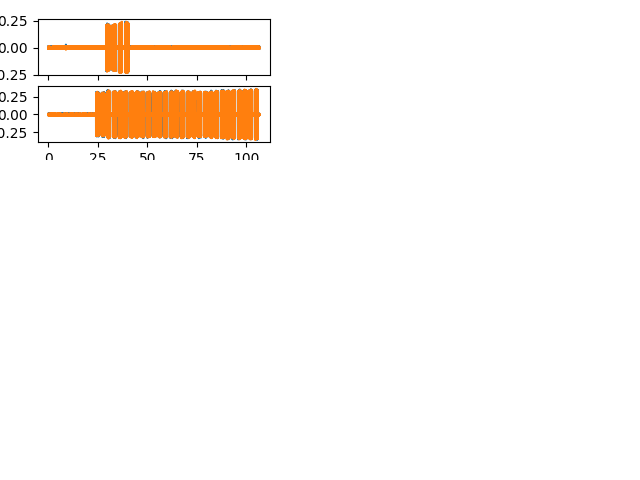

<IPython.core.display.Javascript object>


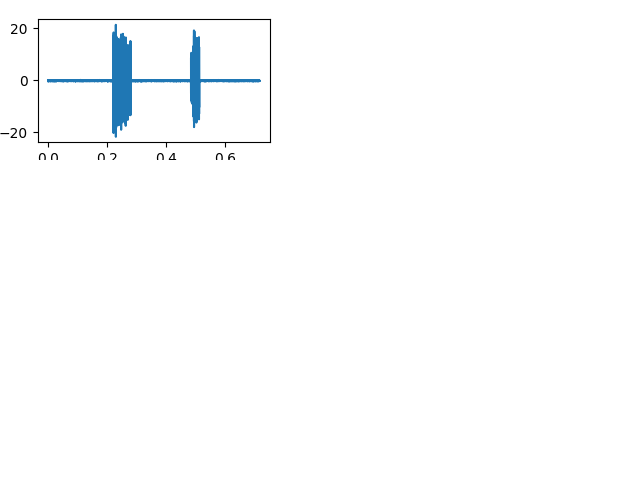

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [42]:
#Import Data
raw0 = np.fromfile(open("open_press0"), dtype=np.complex64)
raw1 = np.fromfile(open("open_press1"), dtype=np.complex64)
int0 = np.fromfile(open("open_press_int"), dtype=np.complex64)
#Constants
fs = 32000 #32k Samples/seconds

#raw0 with respect to time
T0 = np.linspace(0.0, raw0.size/fs, raw0.size)
T1 = np.linspace(0.0, raw0.size/fs, raw1.size)
T_int = np.linspace(0.0, int0.size/fs, int0.size)

T = T0

%matplotlib notebook
plt.figure(0)
plt.subplot(211)
plt.plot(T, raw0.real, T, raw0.imag)
plt.subplot(212)
plt.plot(T1, raw1.real, T1, raw1.imag)


plt.figure(1)
plt.plot(T_int, int0)
plt.show()


In [44]:
#Determine general shape of signal based on 2 different samples where the open button was pressed for different 
#Lengths of time. The open button was pressed for less time in raw0 than raw1.
%matplotlib notebook
plt.figure(1)
#PLT raw0
x_smpl_arr = range(raw0.size)
plt.subplot(211)
plt.plot(T, raw0.real, T, raw0.imag)
#PLT raw1
x_smpl_arr = range(raw1.size)
plt.subplot(212)
plt.plot(T1, raw1.real, T1, raw1.imag)
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


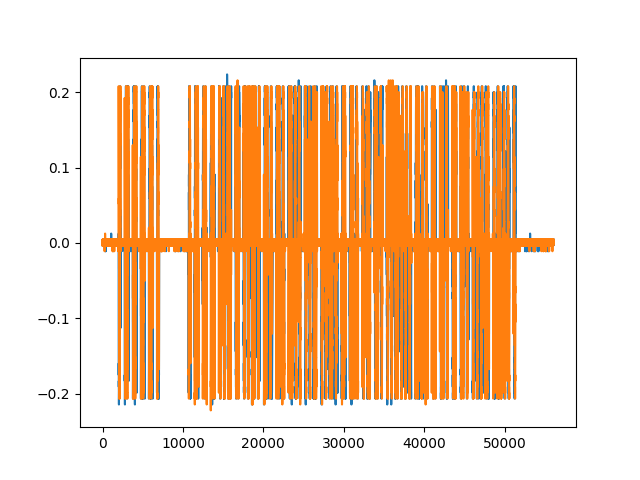

In [47]:
#Now that we can hypothosize that the remote sends a same/similar message the longer the button is pressed, we can 
#isolatethe message based on the first occurence 
#Maybe optimal method is to use derivative like what is used to isolate bits

def isolatePacket(raw_data):
    SMPL_BUFF = 2000 # buffer to 
    PCKT_SIZE_EST = 50000
    tx =abs(raw_data)>.05  
    msg_loc = np.where(tx == True)[0] #locatoins where value non-zero
    start_tx = msg_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
    
    #find end of packet
    diff_msg_loc = np.roll(msg_loc, 1)
    diff_msg_loc[0] = msg_loc[0]
    temp = np.where((msg_loc - diff_msg_loc) > PCKT_SIZE_EST)[0]
    end_tx = msg_loc[temp[0]] - PCKT_SIZE_EST + SMPL_BUFF
  
    return [start_tx, end_tx]

%matplotlib notebook
pkt_size = isolatePacket(raw0)
raw_pkt = raw0[pkt_size[0]:pkt_size[1]]
#x_raw_pkt = T[pkt_size[0]:pkt_size[1]] #For plotting in time
x_raw_pkt = range(raw_pkt.real.size)
plt.figure(2)
plt.plot(x_raw_pkt, raw_pkt.real, x_raw_pkt, raw_pkt.imag)
plt.show()

1900 2500


<IPython.core.display.Javascript object>


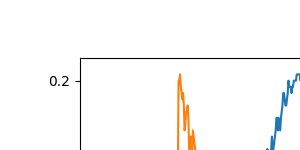

<IPython.core.display.Javascript object>


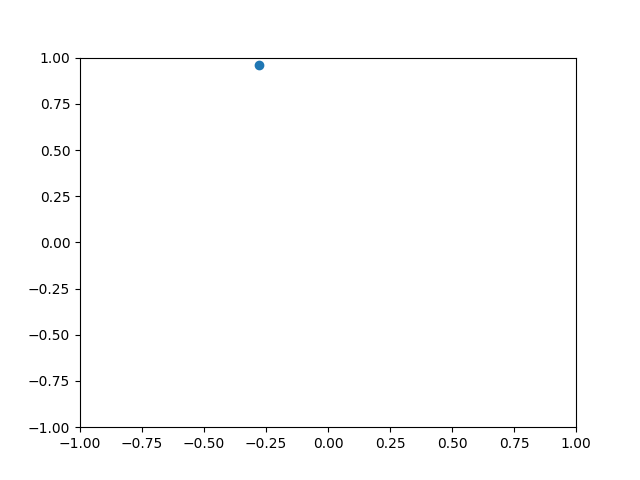

In [48]:
#Isolate bits
#maybe another/smarter way to do this is to use the derivative
#Based on graphical observation of the graph above, I found 4 bit lengths in # of samples. I will average to get an
#    estimated bit length

bLeng_raw = [9.415e5-4.205e5, 9.411e5-9.404e5, 9.431e5-9.425e5, 9.441e5-9.435e5]
BLENG_EST = int (np.sum(bLeng_raw) / len(bLeng_raw))
BLENG_EST = 400

ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
SMPL_BUFF = 100 # buffer to add at the end of the bit for optimal viewing

#Method 1 using zero threshold
tx =abs(raw_pkt)>ZERO_TRESH 
bit_loc = np.where(tx == True)[0] #locations where value non-zero
start_tx = bit_loc[0] - SMPL_BUFF #I know this is dangerous but I'm a badass
end_tx = start_tx + BLENG_EST + 2*SMPL_BUFF

print(start_tx, end_tx)
raw_bit = raw_pkt[start_tx:end_tx]
x_raw_bit = x_raw_pkt[start_tx:end_tx]


%matplotlib notebook
plt.figure(4)
plt.plot(x_raw_bit, raw_bit.real, x_raw_bit, raw_bit.imag)
plt.show()

plt.figure(5)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()

   

<IPython.core.display.Javascript object>


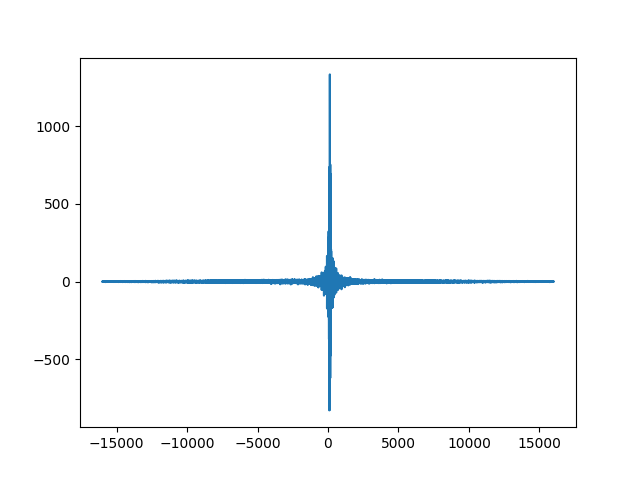

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [49]:
#I want to see what this looks like in freq domain
N = 630000000
fft_pkt = fft.fft(raw_pkt)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

%matplotlib notebook
plt.figure(9)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)


In [50]:
def isolateBitThresh(pkt):
    BLENG_EST = 500     #Bit length estimate in samples
    ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
    SMPL_BUFF = 0 # buffer to add at the end of the bit for optimal viewing

    #pkt = pkt[start:]    #TODO needs to be made more efficient
    tx =abs(pkt)>ZERO_TRESH 
    bit_loc = np.where(tx == True)[0] #locations where value non-zero
    start_tx = bit_loc - SMPL_BUFF #I know this is dangerous but I'm a badass
    end_tx = bit_loc + BLENG_EST + SMPL_BUFF
    bit_bounds = [start_tx, end_tx]
    return (start_tx, end_tx)


(-0.04688096-0.29688096j)


<IPython.core.display.Javascript object>


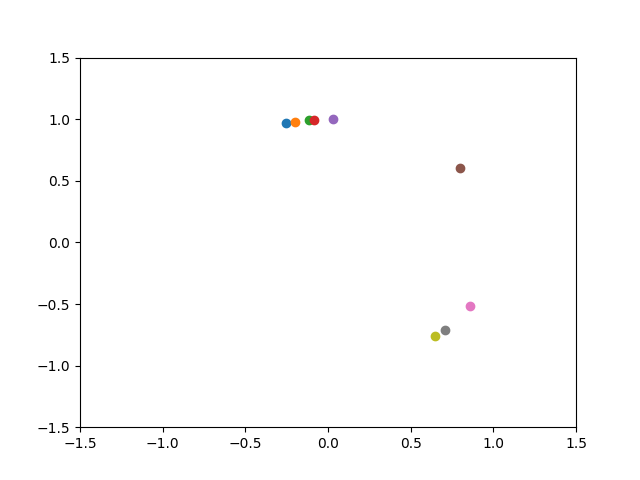

Angle:  104.58297880901334 Raw:  (-0.2517818641237736+0.9677840114913853j)
Angle:  101.60481037303668 Raw:  (-0.20116016248727364+0.9795583642785628j)
Angle:  96.55710131017914 Raw:  (-0.11419335692942771+0.9934585432886409j)
Angle:  94.68611548891896 Raw:  (-0.0816969906566406+0.9966572137488642j)
Angle:  88.3158703183591 Raw:  (0.02938937555594353+0.9995680390070661j)
Angle:  36.87001421748901 Raw:  (0.7999987792629326+0.6000016276459738j)
Angle:  -30.96466165624586 Raw:  (0.8574847979118717-0.5145093015194543j)
Angle:  -45.00050615296585 Raw:  (0.707100534552356-0.7071130277655562j)
Angle:  -49.55410625461597 Raw:  (0.6487296829538653-0.7610189212198192j)


<IPython.core.display.Javascript object>


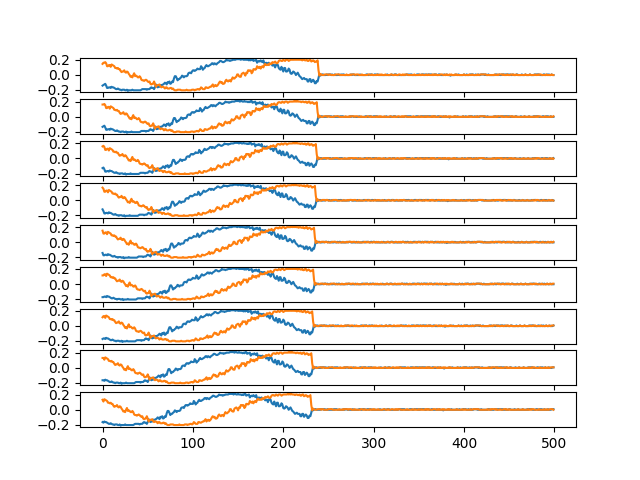

500
500
500
500
500
500
500
500
500


In [105]:
#Get symbol bounds
bounds = isolateBitThresh(raw_pkt)

#Get Symbols
symb = np.empty(bounds[0].size, dtype=complex)
for i in range(bounds[0].size):
    #integrate and dump
    #print(raw_pkt[bounds[0][i]:bounds[1][i]])
    temp = raw_pkt[bounds[0][i]:bounds[1][i]]
    symb[i] = np.sum(temp)
    symb[i] = symb[i] / abs(symb[i])

print(np.sum(raw_pkt[bounds[0][i]:bounds[1][i]]))
#By examining bounds, it is apparent that the function isolateBitThreshold doesn't do a good job identifying
#the bit start locations.
%matplotlib notebook
plt.figure(6)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
for i in range(9):
    print("Angle: ", np.angle(symb[i], deg=True), "Raw: ", symb[i])
    plt.scatter(symb[i].real, symb[i].imag)
plt.show()

plt.figure(7)
const = 10
for i in range(9):
    plt_num = 9*100 + 10 + i+1
    plt.subplot(plt_num)
    symbs = raw_pkt[bounds[0][i+const]:bounds[1][i+const]]
    print(symbs.size)
    plt.plot(range(symbs.size), symbs.real, range(symbs.size), symbs.imag)

<IPython.core.display.Javascript object>


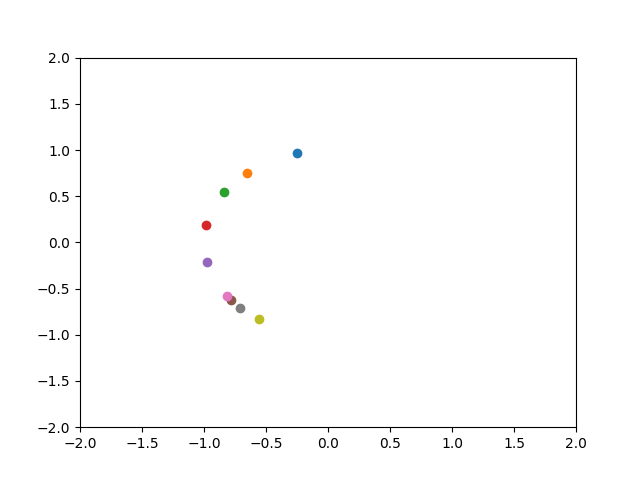

Angle:  104.58336179192318 Raw:  (-0.2517883330891612+0.9677823284810388j)
Angle:  130.97691372397068 Raw:  (-0.6557548794569821+0.7549738658181213j)
Angle:  147.26498723458838 Raw:  (-0.8411804904470004+0.540754456746631j)
Angle:  168.90230972994718 Raw:  (-0.9813004242159612+0.1924824081145455j)
Angle:  -167.52696830956947 Raw:  (-0.9763977740212706-0.21598006131656622j)
Angle:  -141.62178372704656 Raw:  (-0.7839295596734626-0.6208497768946776j)
Angle:  -144.46226313648472 Raw:  (-0.8137328719538612-0.5812390326722051j)
Angle:  -135.1690128478862 Raw:  (-0.7091895469913854-0.7050178624958049j)
Angle:  -123.75185549450742 Raw:  (-0.5555971594462894-0.8314516200087738j)


<IPython.core.display.Javascript object>


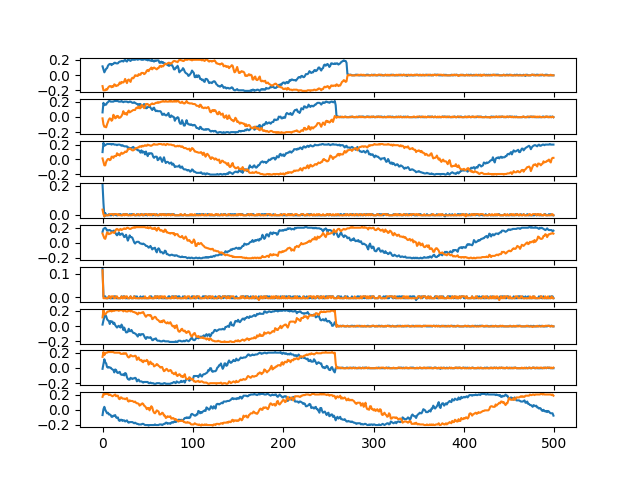

(array([], dtype=int64), array([], dtype=int64))


In [92]:
#Using a loop method to do integrate and dump based on the bit sizes
def isolateBitThreshLoop(pkt):
    BLENG_EST = 500     #Bit length estimate in samples
    ZERO_TRESH = .05    #Determined graphically. Threshold to determine b/t zero and non-zero
    SMPL_BUFF = 6 # buffer to add at the end of the bit for optimal viewing
    
    tx =abs(pkt)>ZERO_TRESH
    symbs = np.empty([int (tx.size/BLENG_EST), BLENG_EST], dtype=complex)
    #print(pkt[0:0+BLENG_EST])
    x = 0; #symbs array iterator
    i = 0
    while tx.size > i:
        if (True == tx[i]):
            #symbs[x] = np.sum(pkt[i:i+BLENG_EST])
            #symbs[x] = symbs[x] / abs(symbs[x])
            symbs[x] = pkt[i:i+BLENG_EST]
            
            x += 1
            i = i + BLENG_EST + SMPL_BUFF
            
        else:
            i += 1
    return symbs

symbs = isolateBitThreshLoop(raw_pkt)
%matplotlib notebook
plt.figure(7)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
for i in range(9):
    symb = np.sum(symbs[i])
    symb = symb / abs(symb)
    print("Angle: ", np.angle(symb, deg=True), "Raw: ", symb)
    plt.scatter(symb.real, symb.imag)
plt.show()

plt.figure(8)
const = 10
for i in range(9):
    plt_num = 9*100 + 10 + i+1
    plt.subplot(plt_num)
    plt.plot(range(symbs[i+const].size), symbs[i+const].real, range(symbs[i+const].size), symbs[i+const].imag)


print(np.where(symbs==False))

In [27]:
print(symbs)
def animate(frame):
    ln.set_data(symbs.real[frame], symbs.imag[frame])
    ln.title("Frame: ", frame)
    return ln

fig, ax = plt.subplots()
ln, = plt.scatter([],[])

ani = FuncAnimation(fig, animate, frames=range(symbs.size))

[-2.51781864e-001+9.67784011e-001j -6.55750813e-001+7.54977398e-001j
 -9.89950402e-001+1.41414996e-001j -8.41177901e-001+5.40758485e-001j
 -9.99039857e-001+4.38105583e-002j -9.81299219e-001+1.92488552e-001j
 -9.43749845e-001-3.30660294e-001j -9.76399150e-001-2.15973842e-001j
 -8.55660000e-001-5.17538371e-001j -7.83929683e-001-6.20849621e-001j
 -8.13733208e-001-5.81238563e-001j -7.09189558e-001-7.05017852e-001j
 -4.76943333e-001-8.78934046e-001j -5.55595937e-001-8.31452437e-001j
 -5.59935123e-002-9.98431133e-001j -1.74866673e-001-9.84592122e-001j
  1.60286036e-001-9.87070609e-001j  6.52592637e-001-7.57708948e-001j
  8.95028560e-001-4.46008830e-001j  9.37623418e-001-3.47652594e-001j
  9.99979486e-001+6.40526570e-003j  8.37492068e-001+5.46449481e-001j
  7.52997098e-001+6.58023838e-001j  4.47213074e-001+8.94427452e-001j
  2.50705710e-002+9.99685684e-001j -1.49999741e-001+9.88686036e-001j
  9.96962175e-001+7.78872317e-002j -7.54776449e-001+6.55982097e-001j
 -9.82968145e-001+1.83776021e-001j

<IPython.core.display.Javascript object>


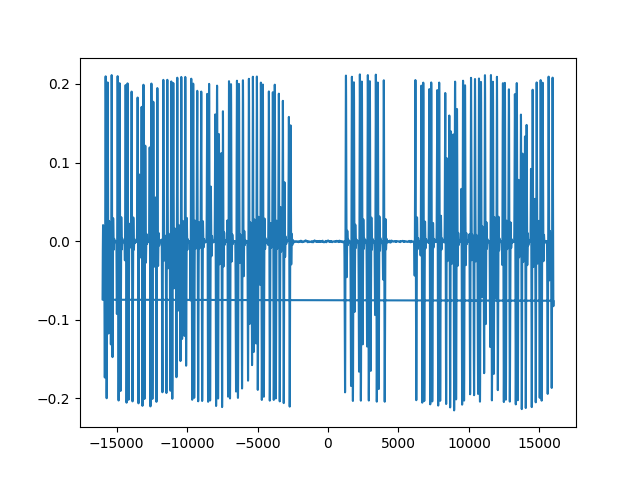

<IPython.core.display.Javascript object>


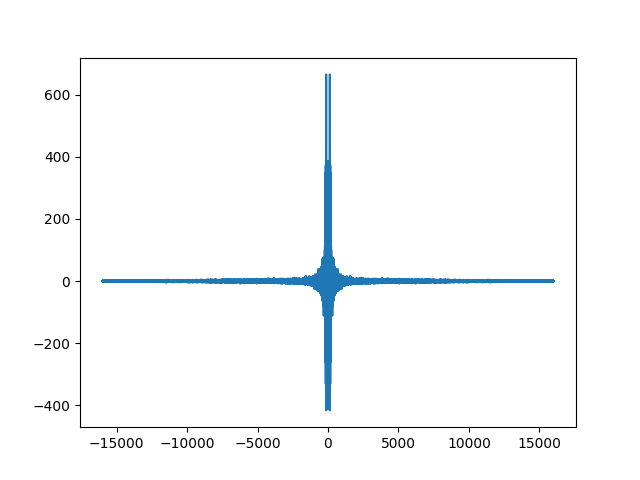

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


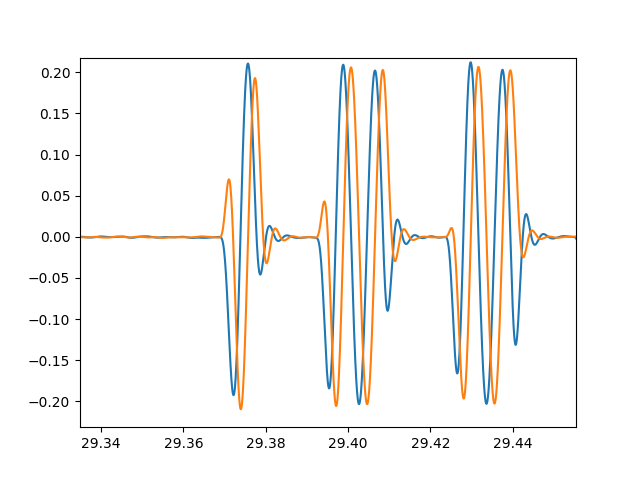

In [106]:
#Low pass filter using butterworth. Cutoff freq at 246 Hz. determined graphically

%matplotlib notebook

nyq = fs / 2
filter_freq = 246 / nyq
b, a = sig.butter(5, 246, 'low', fs=fs)
#taps = sig.firwin(5, 246, fs=fs)
filtered.real = sig.lfilter(b, a, raw_pkt.real)
filtered.imag = sig.lfilter(b, a, raw_pkt.imag)

fft_pkt = fft.fft(filtered.real)

#I Don't Understand why the FT plot looks like fig 9. However when looking at the results in the time domain it
#    looks like the filter works. Maybe a plotting issue???
plt.figure(9)
xf = fft.fftfreq(filtered.size, d=1/fs)
plt.plot(xf, filtered.real)

fft_pkt = fft.fft(raw_pkt.real)
#fft_pkt = fft.fft(np.cos(2*np.pi*T*5000))

plt.figure(10)
xf = fft.fftfreq(raw_pkt.size, d=1/fs)
plt.plot(xf, fft_pkt)

plt.figure(11)
plt.plot(x_raw_pkt, filtered.real, x_raw_pkt, filtered.imag)
#plt.plot(x_raw_pkt, filtered.real)
plt.show()

In [107]:
#LPF fx. 5th order BW filter
#f_cutoff is the cutoff freq for the lpf
def lpf(data, fs, f_cutoff):
    b, a = sig.butter(5, f_cutoff, 'low', fs=fs)
    filtered.real = sig.lfilter(b, a, data.real)
    filtered.imag = sig.lfilter(b, a, data.imag)
    return filtered


<IPython.core.display.Javascript object>


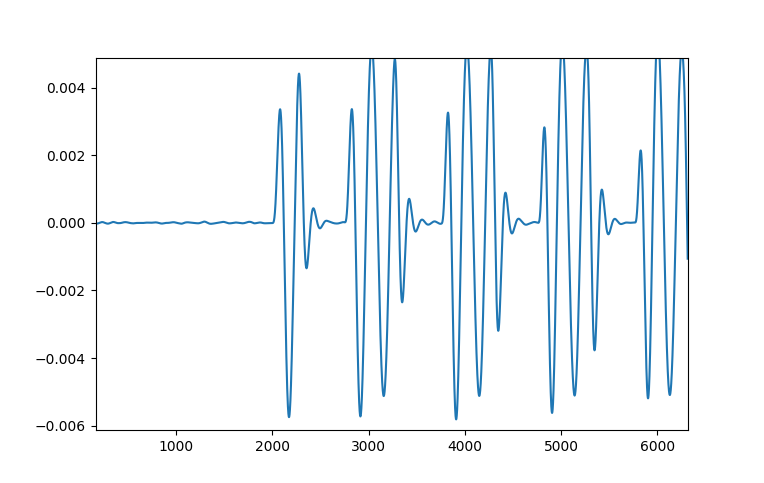

[2148 2149 2150 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161
 2162 2163 2164 2165 2166 2167]
[ 0.01249999-0.00312501j -0.07343751+0.08281249j -0.10468751+0.19999999j
 -0.03437501+0.19999999j -0.05000001+0.20781249j -0.08125001+0.19218749j
 -0.10468751+0.18437499j -0.10468751+0.17656249j -0.10468751+0.18437499j
 -0.13593751+0.16874999j -0.15937501+0.13749999j]
[-1.49294900e-04-0.00092251j -1.40387228e-04-0.00092513j
 -1.31758287e-04-0.00092718j -1.23460631e-04-0.00092858j
 -1.15583272e-04-0.00092919j -1.08260142e-04-0.00092872j
 -1.01678771e-04-0.00092677j -9.60912311e-05-0.00092276j
 -9.18259635e-05-0.00091593j -8.92993516e-05-0.00090533j
 -8.90277293e-05-0.00088985j]
[-1.07553400e-05+7.57149028e-06j -1.06553394e-05+7.14615508e-06j
 -1.05298839e-05+6.69988238e-06j -1.03818801e-05+6.23390827e-06j
 -1.02142758e-05+5.75013821e-06j -1.00296759e-05+5.25110420e-06j
 -9.83037222e-06+4.73980157e-06j -9.61825363e-06+4.21930521e-06j
 -9.39443531e-06+3.69220152e-06j -9.15877167e-06+3.15

<IPython.core.display.Javascript object>


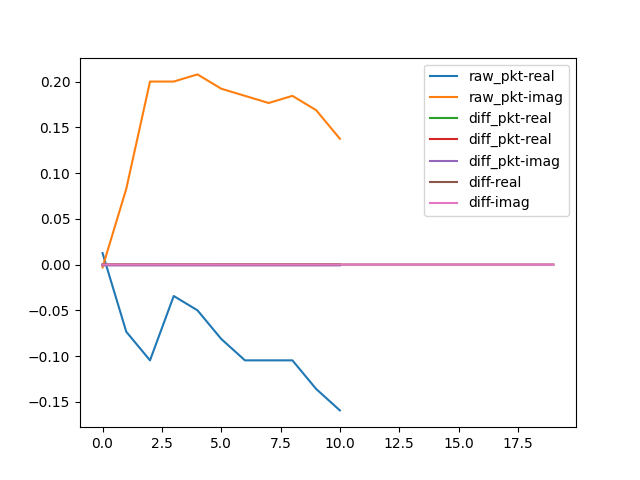

(-0.07343751+0.08281249j)
(-0.0001403872284700353-0.000925127944256726j)
(-8.907671361719447e-06+2.6179227209565054e-06j)


<IPython.core.display.Javascript object>


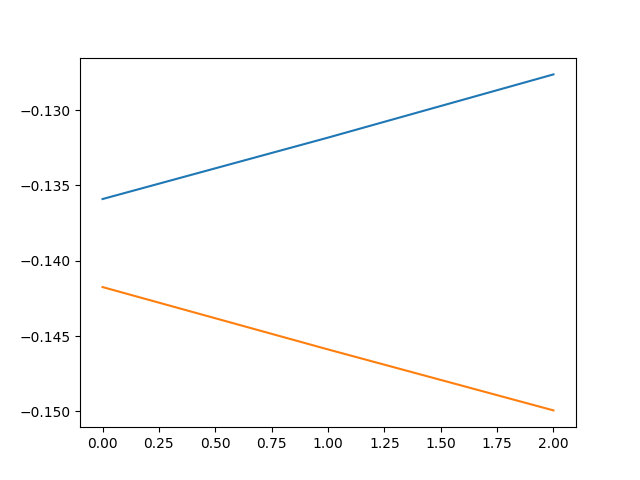

<IPython.core.display.Javascript object>


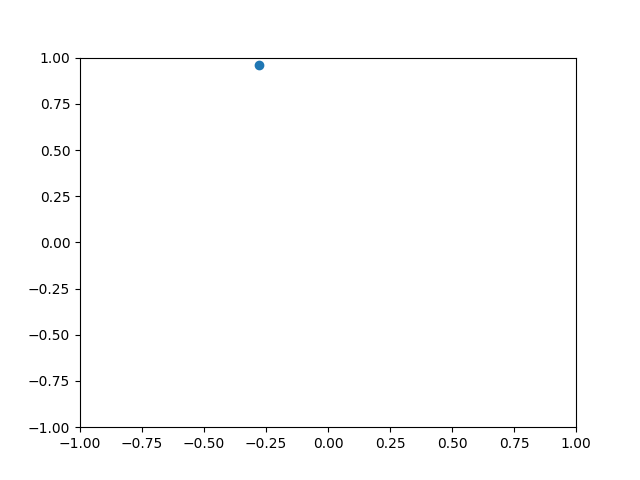

<function matplotlib.pyplot.show(block=None)>

In [110]:
#Method 2 of bit isolations using derivative
#I have abandoned method 2 because it took too much time and method 1 works ok.
# added a LPF IOT to make results more consistent

DIFF_TRESH = .004

filt_pkt = lpf(raw_pkt, fs, 246)
diff_pkt = np.roll(filt_pkt, -1)    #diff_pkt is a copy of raw_pkt shifted 1 to the left

diff_pkt[-1] = filt_pkt[-1] 
diff = filt_pkt - diff_pkt


x_diff = range(diff.size)

%matplotlib notebook
plt.figure(6)
plt.plot(x_diff, diff.real)
plt.show()

tx =abs(diff.real)>=DIFF_TRESH 

bit_loc = np.where(tx == True)[0] #locations where value non-zero
print(bit_loc[0:20])
start_bit = bit_loc[0] 
end_bit = bit_loc[1] + 2

print(raw_pkt[1999:2010])
print(diff_pkt[1999:2010])
print(diff[1990:2010])
print(bit_loc[0])

plt.figure(9)
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].real, label='raw_pkt-real')
plt.plot(range(raw_pkt[1999:2010].size), raw_pkt[1999:2010].imag, label='raw_pkt-imag')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].real, label='diff_pkt-real')
plt.plot(range(diff_pkt[1999:2010].size), diff_pkt[1999:2010].imag, label='diff_pkt-imag')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].real, label='diff-real')
plt.plot(range(diff[1990:2010].size), diff[1990:2010].imag, label='diff-imag')
plt.legend()
plt.show()

print(raw_pkt[2000])
print(diff_pkt[2000])
print(diff[2000])

bit_msg = filt_pkt[start_bit:end_bit]
x_diff = range(bit_msg.size)

plt.figure(7)
plt.plot(x_diff, bit_msg.real, x_diff, bit_msg.imag)
plt.show()

plt.figure(8)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(raw_bit)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show

<IPython.core.display.Javascript object>


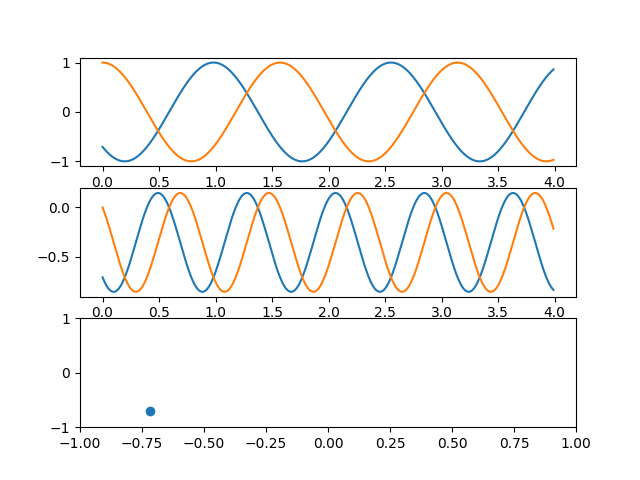

In [47]:
#Understanding Quadrature Demod
%matplotlib notebook

t = np.arange(0, 4, .01)
x = np.cos(4*t + 3*np.pi/4)
x2 =np.cos(4*t)
plt.figure(3)
#Plot original signal
plt.subplot(311)
plt.plot(t, x, t, x2)

#Implement Quadrature demod
comp_data = (x*np.cos(4*t) + 1j*np.sin(4*t)*x)
plt.subplot(312)
plt.plot(t, comp_data.real, t, comp_data.imag)

#Plot Symbol
plt.subplot(313)
plt.xlim(-1,1)
plt.ylim(-1,1)
symb = np.sum(comp_data)
symb = symb / abs(symb)
plt.scatter(symb.real, symb.imag)
plt.show()